In [1]:
import os

import pandas as pd
from tqdm import tqdm

## Load the examples

In [2]:
keywords_gt = pd.read_csv(os.path.join('..', 'data', 'keywords_gt_with_examples.csv'))
# keywords_gt = keywords_gt.rename({'n_keys': 'n_keywords'}, axis=1)
# keywords_gt['presence'] = keywords_gt['presence'].map(lambda x: x if x != 'ERROR' else -1).astype(int)
# keywords_gt.to_csv(os.path.join('..', 'data', 'keywords_gt_with_examples_all.csv'), index=False)

In [3]:
keywords_gt.shape

(1301, 18)

In [4]:
keywords_gt.head()

,country_tag,type,difficulty,r_rsc_id,s_rsc_id,r_pkg_id,s_pkg_id,nl,keywords,prompt_tokens,completion_tokens,presence,response,result_count,top_k,n_keywords,r_id_index,s_id_index
0,CAN,single-table,moderate,a7c95445-e336-41e3-945c-1bc938ff0612,NaN,12c89aa5-063a-f0ed-334a-3019133b9ee8,NaN,What is the total amount paid by each departme...,supplier+payments,1530,372,1,<think>\n\n</think>\n\n## Query Analysis Resul...,17,1000.0,2.0,14.0,NaN
1,CAN,single-table,challenging,a7c95445-e336-41e3-945c-1bc938ff0612,NaN,12c89aa5-063a-f0ed-334a-3019133b9ee8,NaN,Which supplier received the highest payment fr...,new brunswick+supplier,1528,229,1,<think>\n\n</think>\n\n## Query Analysis Resul...,10,1000.0,2.0,7.0,NaN
2,CAN,single-table,simple,ae2204c7-db9e-450e-8158-c70eedada7ae,NaN,4879e498-c9ac-44a3-d7d1-21af22e2224c,NaN,"Which suppliers received payments over $100,00...",suppliers+new brunswick,1530,360,1,<think>\n\n</think>\n\n## Query Analysis Resul...,10,1000.0,2.0,5.0,NaN
3,CAN,single-table,moderate,ae2204c7-db9e-450e-8158-c70eedada7ae,NaN,4879e498-c9ac-44a3-d7d1-21af22e2224c,NaN,According to the Government of New Brunswick’s...,public accounts+new brunswick,1531,356,1,<think>\n\n</think>\n\n## Query Analysis Resul...,34,1000.0,2.0,22.0,NaN
4,CAN,single-table,challenging,ae2204c7-db9e-450e-8158-c70eedada7ae,NaN,4879e498-c9ac-44a3-d7d1-21af22e2224c,NaN,According to the Government of New Brunswick’s...,supplier+new brunswick,1524,204,1,<think>\n\n</think>\n\n## Query Analysis Resul...,10,1000.0,2.0,5.0,NaN


In [5]:
data = keywords_gt[
    (keywords_gt['n_keywords'] == 2) & 
    (keywords_gt['presence'] == 1) &
    (keywords_gt['r_id_index'] < 50) &
    ((keywords_gt['s_id_index'] < 50) | (pd.isna(keywords_gt['s_id_index'])))
].iloc[:].sample(100, random_state=42)

data.shape

(100, 18)

In [6]:
data[(data['r_id_index'] < 30) & (data['s_id_index'] < 30)].shape[0]

7

## Fetching Packages and relative Tables

In [8]:
from ckan import CanadaCKAN

ckan_client = CanadaCKAN() 

In [ ]:
data.iloc[0]['r_pkg_id']

'12c89aa5-063a-f0ed-334a-3019133b9ee8'

In [139]:
r = ckan_client.package_show(id=data.iloc[0]['r_pkg_id'])

In [145]:
del r['result']['resources']

In [147]:
r['result']

{'aggregate_identifier': '',
 'association_type': [],
 'audience': [],
 'author': None,
 'author_email': None,
 'collection': 'federated',
 'contact_information': '{"fr": {"organization_name": "Finances et Conseil du Trésor","electronic_mail_address": "opendatadonneesouvertes@snb.ca"},"en": {"organization_name": "Finance and Treasury Board","electronic_mail_address": "opendatadonneesouvertes@snb.ca"}}',
 'contributor': {},
 'creator_user_id': 'b88b9549-3a4b-43a9-9375-5f3fc20fe782',
 'data_series_issue_identification': {},
 'data_series_name': {},
 'date_published': '2021-10-28 00:00:00',
 'display_flags': [],
 'federated_date_modified': '2024-07-09',
 'file_id': '12c89aa5-063a-f0ed-334a-3019133b9ee8',
 'frequency': 'unknown',
 'geographic_region': [],
 'hierarchy_level': 'dataset; jeuDonnées',
 'id': '12c89aa5-063a-f0ed-334a-3019133b9ee8',
 'imso_approval': 'true',
 'isopen': False,
 'jurisdiction': 'provincial',
 'keywords': {'en': ['supplier lists',
   'listes de fournisseurs',
   'p

In [9]:
import os
import shutil

shutil.rmtree('tmp')
os.makedirs('tmp', exist_ok=True)

cnt = ckan_client.download_tables_from_package_search('tmp', 'csv', 3, q='suppliers+payments', rows=20, defType='edismax', sort='sort desc')

cnt

https://open.canada.ca/data/api/3/action/package_search?q=suppliers+payments&rows=20&defType=edismax&sort=sort desc


53

In [10]:
resource_ids = list(map(lambda s: s.removesuffix('.csv'), os.listdir('tmp')))

data['r_rsc_id'][0] in resource_ids, data['s_rsc_id'][0] in resource_ids

(True, True)

## Setup the BLEND index with ALL the downloaded resources

Parsing and storing tables: 100%|██████████| 10/10 [00:00<00:00, 12.13it/s]


Tables ingestion completed.
Creating indexes...
Index creation completed.


In [10]:
import duckdb
dbcon = duckdb.connect(os.path.join('data', 'blend.db'))
dbcon.close()

In [4]:
dbcon.sql("DROP TABLE IF EXISTS AllTables CASCADE;")

In [ ]:
subset_ids = os.listdir(os.path.join('data', 'tmp'))[:10]
searcher.create_index(os.path.join('data', 'tmp'), subset_ids, max_workers=6, limit_table_rows=100, verbose=True)

Parsing and storing tables:   0%|          | 0/10 [00:45<?, ?it/s]


In [5]:
import duckdb

dbcon = duckdb.connect(os.path.join('data', 'blend.db'))
dbcon.table('AllTables').show()

┌──────────────────────────────────────────────┬──────────────────────────────────────┬──────────┬────────┬──────────────────┬─────────────┬──────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                  CellValue                   │               TableId                │ ColumnId │ RowId  │ GranularityClass │ Granularity │ Quadrant │                                                             SuperKey                                                             │
│                   varchar                    │               varchar                │  uint32  │ uint32 │     varchar      │   varchar   │ boolean  │                                                               blob                                                               │
├──────────────────────────────────────────────┼──────────────────────────────────────┼──────────┼────────┼──────────────────┼─────────────┼──────────┼

In [141]:
dbcon.sql("SELECT COUNT(*) FROM AllTables;")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│         2288 │
└──────────────┘

In [ ]:
import os
import re
from typing import Dict, List, Literal

import polars as pl

from blend import BLEND


def search_single_joins(
    tables_path: str,
    searcher: BLEND | None = None,
    db_path: str | None = None,
    table_ids: List[str] | None = None,
    format: Literal["csv", "parquet"] = "csv",
    join_on_columns: Dict[str, List[int]] | None = None,
    k: int = 3,
    **blend_kwargs,
) -> List[Dict]:
    """
    Run a single-column-join search on the given tables.

    :param tables_path: directory where table (CSV/parquet) files are stored.
    :param searcher: an instance of BLEND searcher. If None, db_path is required to create a new one.
    :param db_path: a path where to store the BLEND database, required if searcher parameter is None.
    :param table_ids: a subset of table IDs (without any type extension) to use for the search. If None, all tables are used.
    :param format: format of tables. Default is CSV.
    :param join_on_columns: a dictionary where, for each table,
                            is provided a list of columns on which the search is performed.
                            If None, the search is done over every column of every tables.
    :param k: number of results to return for each search.
    :param blend_kwargs: keyword arguments passed to blend.create_index.
    :return: a list of dictionaries, where each reports the pair of tablees and columns and the relative overlap.
    """

    # take table IDs
    table_ids = list(filter(
        lambda _id: True if table_ids is None else _id in table_ids,
        map(lambda _id: re.sub(r"(.csv|.parquet)$", "", _id), os.listdir(tables_path)),
    ))

    if not searcher:
        searcher = BLEND(db_path)
        searcher.create_index(data_path=tables_path, **blend_kwargs)

    results = []

    for table_id in table_ids:
        n_rows = blend_kwargs.get("limit_table_rows", None)

        # read the current query table
        match format:
            case "csv":
                df = pl.read_csv(
                    os.path.join(tables_path, table_id + ".csv"), n_rows=n_rows
                )
            case "parquet":
                df = pl.read_parquet(
                    os.path.join(tables_path, table_id + ".parquet"), r_rows=n_rows
                )

        # for each column, perform a signle-join-search
        for column in df.columns:
            # if this column is not in the subset of
            # selected columns for this table, continue
            if (
                join_on_columns
                and table_id in join_on_columns
                and column not in join_on_columns[table_id]
            ):
                continue

            query_values = df.get_column(column).to_list()

            # perform the search with BLEND
            res = searcher.single_column_join_search(query_values, k)

            for res_table_id, res_column_id, overlap in res:
                match format:
                    case "csv":
                        r_df = pl.read_csv(
                            os.path.join(tables_path, res_table_id + ".csv"), n_rows=0
                        )
                    case "parquet":
                        r_df = pl.read_parquet(
                            os.path.join(tables_path, res_table_id + ".parquet"),
                            r_rows=0,
                        )

                results.append(
                    {
                        "left_table": table_id,
                        "left_column": column,
                        "right_table": res_table_id,
                        "right_column": r_df.columns[res_column_id],
                        "overlap": overlap,
                    }
                )

    return results


def main():
    pass


if __name__ == "__main__":
    main()


In [5]:
import re 

query_tables = os.listdir(os.path.join('data', 'tmp'))[11:13]
query_tables = list(map(lambda _id: re.sub(r"(\.csv|\.parquet)", "", _id), query_tables))

results = search_single_joins(os.path.join('data', 'tmp'), searcher, os.path.join('data', 'blend.db'), query_tables)

['f4b00406-0e71-4ac1-b78b-0faa732a210e', '77296379-7101-4638-a0e8-ad779996f010']


In [6]:
results

[{'left_table': 'f4b00406-0e71-4ac1-b78b-0faa732a210e',
  'left_column': 'Payment / Paiement',
  'right_table': 'f838d643-e46c-4c90-adf2-d5b8ea694298',
  'right_column': 'Payment / Paiement',
  'overlap': 10},
 {'left_table': 'f4b00406-0e71-4ac1-b78b-0faa732a210e',
  'left_column': 'Payment / Paiement',
  'right_table': '18c17dcf-617d-44d7-b351-6fd7c3fc6b48',
  'right_column': 'Amount',
  'overlap': 4},
 {'left_table': 'f4b00406-0e71-4ac1-b78b-0faa732a210e',
  'left_column': 'Payment / Paiement',
  'right_table': 'a99c50a4-a2f8-4613-9f51-2c5ebb6f4445',
  'right_column': 'Payment / Paiement',
  'overlap': 3},
 {'left_table': '77296379-7101-4638-a0e8-ad779996f010',
  'left_column': 'Payment / Paiement',
  'right_table': 'f838d643-e46c-4c90-adf2-d5b8ea694298',
  'right_column': 'Payment / Paiement',
  'overlap': 100},
 {'left_table': '77296379-7101-4638-a0e8-ad779996f010',
  'left_column': 'Payment / Paiement',
  'right_table': 'a99c50a4-a2f8-4613-9f51-2c5ebb6f4445',
  'right_column': 'Pa

In [ ]:
s_rsc_metadata = ckan_client.resource_show(resource_id=data['s_rsc_id'][0])

In [ ]:
response = ckan_client.package_search("payment+supplier", 3)

In [1]:
# get name of csvs in downloads folder
import os
csv_files = [f for f in os.listdir('../downloads') if f.endswith('.csv')
                and not f.startswith('._') and not f.startswith('.')]
print(csv_files)

# remove .csv from filenames
csv_files = [f.removesuffix('.csv') for f in csv_files]

csv_files

['5935eeed-d098-472c-a9ee-9a2f110ad774.csv', '1bf14924-fbf1-4751-81f8-303500e423cc.csv', 'a7c95445-e336-41e3-945c-1bc938ff0612.csv', 'ae2204c7-db9e-450e-8158-c70eedada7ae.csv', '6730abbb-c9c8-420e-8212-3b469919e488.csv', '61f67f87-aebf-4d94-b34e-7bed82375589.csv', 'e5a6ce4d-cdda-4694-a06f-bec1a0079915.csv', '894f8bee-a888-4bc5-bc2d-caf3214316fc.csv', 'c1b40c98-e75b-476e-b1e4-fbff314b84ec.csv', '46131b54-5905-4e44-96b2-446bab3eb974.csv']


['5935eeed-d098-472c-a9ee-9a2f110ad774',
 '1bf14924-fbf1-4751-81f8-303500e423cc',
 'a7c95445-e336-41e3-945c-1bc938ff0612',
 'ae2204c7-db9e-450e-8158-c70eedada7ae',
 '6730abbb-c9c8-420e-8212-3b469919e488',
 '61f67f87-aebf-4d94-b34e-7bed82375589',
 'e5a6ce4d-cdda-4694-a06f-bec1a0079915',
 '894f8bee-a888-4bc5-bc2d-caf3214316fc',
 'c1b40c98-e75b-476e-b1e4-fbff314b84ec',
 '46131b54-5905-4e44-96b2-446bab3eb974']

In [2]:
import sys
sys.path.append('..')
from search_relations import search_single_joins

search_single_joins(tables_path='/home/angelo.mozzillo/lakegen_demo/downloads', db_path='blend.db', table_ids=csv_files, limit_table_rows=1000, max_workers=6)

['5935eeed-d098-472c-a9ee-9a2f110ad774.csv', '1bf14924-fbf1-4751-81f8-303500e423cc.csv', 'a7c95445-e336-41e3-945c-1bc938ff0612.csv', 'ae2204c7-db9e-450e-8158-c70eedada7ae.csv', '6730abbb-c9c8-420e-8212-3b469919e488.csv', '61f67f87-aebf-4d94-b34e-7bed82375589.csv', 'e5a6ce4d-cdda-4694-a06f-bec1a0079915.csv', '894f8bee-a888-4bc5-bc2d-caf3214316fc.csv', 'c1b40c98-e75b-476e-b1e4-fbff314b84ec.csv', '46131b54-5905-4e44-96b2-446bab3eb974.csv']
Searching in tables: ['5935eeed-d098-472c-a9ee-9a2f110ad774', '1bf14924-fbf1-4751-81f8-303500e423cc', 'a7c95445-e336-41e3-945c-1bc938ff0612', 'ae2204c7-db9e-450e-8158-c70eedada7ae', '6730abbb-c9c8-420e-8212-3b469919e488', '61f67f87-aebf-4d94-b34e-7bed82375589', 'e5a6ce4d-cdda-4694-a06f-bec1a0079915', '894f8bee-a888-4bc5-bc2d-caf3214316fc', 'c1b40c98-e75b-476e-b1e4-fbff314b84ec', '46131b54-5905-4e44-96b2-446bab3eb974']
Creating a new BLEND searcher with db_path: blend.db
Searching in table 5935eeed-d098-472c-a9ee-9a2f110ad774...
Number of rows to read: 1

TypeError: Plan.__init__() missing 1 required positional argument: 'db'

## Packages pre-filtering

If we can **pre-filter** tables by checking their relevance from package metadata, we can download and post-process **few data** and **reduce the search space** for the subsequent table-selector agent

### Setup Agent and Prompts

In [4]:
import os

from dotenv import load_dotenv
from autogen_core.models import UserMessage
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import StructuredMessage
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

In [5]:
# same seed for any random operation
seed = 42

# Load environment variables from .env file
load_dotenv()
assert "TOGETHER_API_KEY" in os.environ

settings = {
    "model": "Qwen/Qwen3-235B-A22B-fp8-tput",
    "temperature": 0.1,
    "top_p": 1,
    "frequency_penalty": 0,
    "presence_penalty": 0,
    "max_tokens": 10000,
}

model_client = OpenAIChatCompletionClient(
    base_url = "https://api.together.xyz/v1/",
    api_key=os.getenv("TOGETHER_API_KEY", ""),
    model_info= {
        "vision": False,
        "function_calling": True,
        "json_output": True,
        "family": "unknown",
        "structured_output": True
    },
    **settings   
)

In [91]:
with open(os.path.join('prompts', 'TablePreFilter.md')) as file:
    TABLE_PRE_FILTER_SYSTEM_PROMPT = file.read()

with open(os.path.join('prompts', 'TablePreFilter-task.md')) as file:
    TABLE_PRE_FILTER_TASK_PROMPT = file.read()

with open(os.path.join('prompts', 'TablePreFilter-allatonce.md')) as file:
    TABLE_PRE_FILTER_ALL_SYSTEM_PROMPT = file.read()

TABLE_PRE_FILTER_ALL_TASK_QUESTION_PROMPT = "<question>{question}</question>"
TABLE_PRE_FILTER_ALL_TASK_PACKAGE_PROMPT = "<package>{title}</package><notes>{notes}</notes>"

In [74]:
# analyze packages one-by-one, 
# without a overall view of available packages
analyzer = AssistantAgent(
    name="TablePreFilter", 
    model_client=model_client, 
    system_message=TABLE_PRE_FILTER_SYSTEM_PROMPT
)

In [92]:
# analyze packages all-at-once
analyzer_all = AssistantAgent(
    name="TablePreFilter_all", 
    model_client=model_client, 
    system_message=TABLE_PRE_FILTER_ALL_SYSTEM_PROMPT
)

### Prepare data for querying the agent

In [68]:
data

,country_tag,type,difficulty,r_rsc_id,s_rsc_id,r_pkg_id,s_pkg_id,r_col_name,s_col_name,nl,top_k,n_keywords,keywords,presence,result_count,r_id_index,s_id_index,prompt_tokens,completion_tokens,response
0,CAN,multi-table-join,simple,ce336623-43d6-4e5d-81d8-26fb9145cf92,ab5df4ac-7f55-461b-934f-d7af48d18e6f,2f40fb8f-a9e7-4f5b-94e9-04fbfaa10676,2013c544-62e8-4485-ad4b-6e5ba5e373b9,coa_segment_04_l3_and_desc,coa_segment_04_l3_and_desc,How do the operating expenses for different fi...,1000,2,british columbia+operating expenses,1,47,0.0,31.0,649,19,<think>\n\n</think>\n\n<keywords>british colum...


In [69]:
keywords = data['keywords'][0]
keywords

'british columbia+operating expenses'

In [100]:
from ckan import CanadaCKAN

ckan_client = CanadaCKAN() 

ckan_response = ckan_client.package_search(q=keywords, rows=50, defType='edismax', sort='sort desc')

https://open.canada.ca/data/api/3/action/package_search?q=british columbia+operating expenses&rows=50&defType=edismax&sort=sort desc


In [101]:
packages = ckan_response['result']['results']

In [102]:
data['nl'][0]

"How do the operating expenses for different fiscal years compare between the 2018 and 2023 supplementary estimates for various ministries in the Government of British Columbia budget? Specifically, I'm interested in seeing the alignment of these expenses based on their specific cost categories like salaries and benefits or operating costs."

In [105]:
desired_package_ids = [data['r_pkg_id'][0], data['s_pkg_id'][0]]

In [106]:
for d in desired_package_ids:
    s = False
    for p in packages:
        if p['id'] == d:
            s = True
            break
    print(d, s)

2f40fb8f-a9e7-4f5b-94e9-04fbfaa10676 True
2013c544-62e8-4485-ad4b-6e5ba5e373b9 True


### Query the Agent

In [ ]:
# ask the agent for an answer. If no_think=True, the thinking process is truncated.
# A much shorter time is required for this option
no_think = False
model_choices = []

for package in tqdm(packages[:0]):
    # print(package['title'])
    # print(package['notes'])
    # print(', '.join(package['keywords']['en']))
    # print()
    prompt = TABLE_PRE_FILTER_TASK_PROMPT.format(
        question=data['nl'][0],
        title=package['title'],
        # notes='N/A', 
        notes=package['notes'][:300],
        keywords='N/A' # ', '.join(package['keywords']['en'])
        # keywords=', '.join(package['keywords']['en'])
    )

    if no_think:
        prompt = '/nothink' + ' ' + prompt

    response = await analyzer.run(task=prompt)
    response = response.messages[-1]
    model_choices.append(response)

100%|██████████| 17/17 [06:10<00:00, 21.77s/it]


In [113]:
# ask the agent for an answer. If no_think=True, the thinking process is truncated.
# A much shorter time is required for this option
no_think = True
model_allatonce_choices = []

prompt = TABLE_PRE_FILTER_ALL_TASK_QUESTION_PROMPT
prompt = prompt.format(question=data['nl'][0])

for package in packages:
    prompt += TABLE_PRE_FILTER_ALL_TASK_PACKAGE_PROMPT.format(
        title=package['title'],
        notes=package['notes'][:200]
    ) + '\n'

if no_think:
    prompt = '/nothink' + ' ' + prompt

response = await analyzer_all.run(task=prompt)
response = response.messages[-1]
model_allatonce_choices.append(response)

In [127]:
analyzer_all.create

AttributeError: 'AssistantAgent' object has no attribute 'create'

In [114]:
# extract the YES/NO answer from the agent reply
import re

answers = [
    re.search(r"<answer>(YES|NO)</answer>", message.content).group(1)
    for message in model_choices
]

answers = list(zip(answers, [p['id'] for p in ckan_response['result']['results']]))
answers = [a[1] for a in answers if a[0] == 'YES']
# answers

In [116]:
answers = re.findall(r"<package>(.*)</package><answer>(YES|NO)</answer>", model_allatonce_choices[0].content)
answers = [(i['id'], a[0]) for i, a in zip(packages, answers) if a[1] == 'YES']
selected_ids = [a[0] for a in answers]
answers

[('2f40fb8f-a9e7-4f5b-94e9-04fbfaa10676',
  'Budget 2023 - Supplement to the Estimates'),
 ('2013c544-62e8-4485-ad4b-6e5ba5e373b9',
  'Budget 2018 - Supplement to the Estimates')]

In [117]:
for i, package in tqdm(enumerate(ckan_response['result']['results'])):
    if package['id'] in selected_ids:
        print(str(i) + ' ' + package['id'])
        print(str(i) + ' ' + package['title'])
        # print(package['notes'][:300])
    if package['id'] in desired_package_ids:
        print(str(i) + ' ' + '>>> ' + package['id'])
        print(str(i) + ' ' + '>>> ' + package['title'])

47it [00:00, 70203.81it/s]

0 2f40fb8f-a9e7-4f5b-94e9-04fbfaa10676
0 Budget 2023 - Supplement to the Estimates
0 >>> 2f40fb8f-a9e7-4f5b-94e9-04fbfaa10676
0 >>> Budget 2023 - Supplement to the Estimates
31 2013c544-62e8-4485-ad4b-6e5ba5e373b9
31 Budget 2018 - Supplement to the Estimates
31 >>> 2013c544-62e8-4485-ad4b-6e5ba5e373b9
31 >>> Budget 2018 - Supplement to the Estimates


In [86]:
desired_package_ids[0], desired_package_ids[0] in selected_ids, desired_package_ids[1], desired_package_ids[1] in selected_ids

('2f40fb8f-a9e7-4f5b-94e9-04fbfaa10676',
 True,
 '2013c544-62e8-4485-ad4b-6e5ba5e373b9',
 False)

In [87]:
data['nl'][0]

"How do the operating expenses for different fiscal years compare between the 2018 and 2023 supplementary estimates for various ministries in the Government of British Columbia budget? Specifically, I'm interested in seeing the alignment of these expenses based on their specific cost categories like salaries and benefits or operating costs."

In [111]:
with open('answers/missing_package_with_all_packages.txt', 'w') as file:
    file.write(model_allatonce_choices[0].content)

In [121]:
model_allatonce_choices[0]

TextMessage(id='14cc1647-8bbe-4bfa-9e7c-9b0d2a4ef513', source='TablePreFilter_all', models_usage=RequestUsage(prompt_tokens=11346, completion_tokens=1506), metadata={}, created_at=datetime.datetime(2025, 7, 25, 9, 19, 57, 712520, tzinfo=datetime.timezone.utc), content='<think>\n\n</think>\n\n<package>Budget 2023 - Supplement to the Estimates</package><answer>YES</answer>  \n<package>Operating Statement Tbl 2.1</package><answer>NO</answer>  \n<package>Historical Operating Statement Surplus (Deficit) Tbl A2.14</package><answer>NO</answer>  \n<package>BC Finance - Standard Object of Expense</package><answer>NO</answer>  \n<package>Budget 2013 June Update - Provincial Debt Summary Tbl 1.17</package><answer>NO</answer>  \n<package>Historical Operating Statement Surplus (Deficit), 1969-1970 to 2011-12 Tbl A2.14</package><answer>NO</answer>  \n<package>Budget 2012 - Provincial Debt Tbl 1.20</package><answer>NO</answer>  \n<package>Budget 2014 - Ten-Year Operating Statement 2007-08 to 2016-17 

### Results from evaluate_allatonce.py

In [132]:
import os
import pandas as pd

df = pd.read_csv(os.path.join('data', 'allatonce_evaluation_k30.csv'))
df = pd.read_csv(os.path.join('data', 'embedding_eval_k30.csv'))

In [133]:
X = df[['r_present', 'r_selected']].dropna().map(int)
y_true = X['r_present'].values.reshape((-1, 1))
y_pred = X['r_selected'].values.reshape((-1, 1))
y_true.shape, y_pred.shape

((100, 1), (100, 1))

In [134]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)


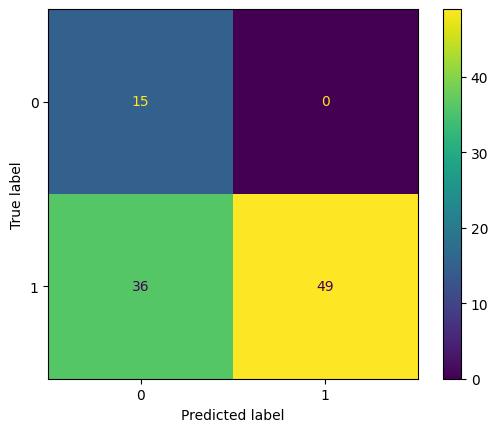

In [135]:
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Resources Pre-Filtering

Once we have selected a small subset of all the available packages, again we can choose which resources satisfy us most: a model should avoid to download same datasets from different formats (e.g. CSV and XLSX) or languages (EN vs FR)

In [10]:
from ckan import CanadaCKAN

ckan_client = CanadaCKAN()

In [133]:
i = 23
idx = data.index[i]
question = data.loc[idx]['nl']
r_pkg_id = data.loc[idx]['r_pkg_id']
s_pkg_id = data.loc[idx]['s_pkg_id']
r_rsc_id = data.loc[idx]['r_rsc_id']
r_pkg_id, s_pkg_id

('a5cb7c3c-0371-4a20-ac9a-98fc4c3536bb', nan)

In [134]:
package_metadata = ckan_client.package_show(id=r_pkg_id)['result']

In [135]:
r_rsc_id

'fb79c2c3-27fe-454e-b9ee-6d1049ea41eb'

In [136]:
from tabulate import tabulate

x = []
for r in package_metadata['resources']:
    x.append((r['name'], r['id'], '<<<' if r['id'] == r_rsc_id else ''))
print(tabulate(x))

---------------------------------------------  ------------------------------------  ---
Appendix B1 of 2020-2021 NCRMP Report EN       001d3db4-8af8-4259-a017-09604beab006
Appendix B1 of 2020-2021 NCRMP Report FR       e0b83ef3-40d0-470b-90df-62699ab742d1
Appendix B2 of 2020-2021 NCRMP Report EN       73358490-423c-4b54-a6e1-383828e4efd7
Appendix B2 of 2020-2021 NCRMP Report FR       c541e163-6fb9-472d-9b48-97d067c84a5f
Appendix B3 of 2020-2021 NCRMP Report EN       fb79c2c3-27fe-454e-b9ee-6d1049ea41eb  <<<
Appendix B3 of 2020-2021 NCRMP Report FR       6c8b55db-546f-487a-981e-4a5e92224680
Appendix B4 of 2020-2021 NCRMP Report EN       8180a735-fa80-4f54-adeb-072ce0c25611
Appendix B4 of 2020-2021 NCRMP Report FR       02705d98-4402-49df-bdd2-6238e505a17e
Appendix B5 of 2020-2021 NCRMP Report EN       b03de182-7e2b-4818-9228-ad8d0b3c84da
Appendix B5 of 2020-2021 NCRMP Report FR       8929476e-21b7-421f-8aeb-a9108d4bcb1c
Appendix B6 of 2020-2021 NCRMP Report EN       bff2426f-7c57-49e0-

In [132]:
question

"According to Statistics Canada's data on new housing prices, what are the average values of the indexes for houses and land across various base years when there is no reported status?"

A first simple filter is on data format: ONLY CSVs are ACCEPTED

Another one is on language: here we want to work only on ENGLISH resources

In [127]:
res = package_metadata['resources'][:]

apply_filters = True

def format_f(resource):
    return resource['format'] == 'CSV'

def language_f(resource):
    return 'language' in resource and 'en' in resource['language']

def resource_type_f(resource):
    return 'resource_type' in resource and resource['resource_type'] == 'dataset'


if apply_filters:
    res = list(
        filter(format_f, 
               filter(language_f, 
                      filter(resource_type_f, res
                    )
                )
            )
        )

keys = res[0].keys()

x = []

for r in res:
    v = ['>>>' if r['id'] == r_rsc_id else '']
    for k in keys:
        if k in r:
            v.append(r[k])
        else:
            v.append(None)
    x.append(v)



print(tabulate(x, headers=['resource'] + list(keys)))

resource    cache_last_updated    cache_url    character_set    created                     data_quality            datastore_active    datastore_contains_all_records_of_source_file    date_published    description    format    hash    id                                    language    last_modified    metadata_modified           mimetype    mimetype_inner    name                                                          name_translated                                                                                                                                      package_id                              position  resource_type    state    unique_identifier    url                                                                                                                                                                     url_type
----------  --------------------  -----------  ---------------  --------------------------  ----------------------  ------------------  ------------------

In [60]:
keys

dict_keys(['cache_last_updated', 'cache_url', 'character_set', 'created', 'data_quality', 'datastore_active', 'datastore_contains_all_records_of_source_file', 'date_published', 'description', 'format', 'hash', 'id', 'language', 'last_modified', 'metadata_modified', 'mimetype', 'mimetype_inner', 'name', 'name_translated', 'package_id', 'position', 'related_relationship', 'related_type', 'resource_type', 'state', 'unique_identifier', 'url', 'url_type'])

In [73]:
keys

dict_keys(['aafc_resource_metadata_schema', 'aafcdc_evaluation_feedback', 'cache_last_updated', 'cache_url', 'character_set', 'created', 'data_quality', 'data_source_repository', 'datastore_active', 'datastore_contains_all_records_of_source_file', 'date_published', 'description', 'format', 'hash', 'id', 'language', 'last_modified', 'metadata_modified', 'mimetype', 'mimetype_inner', 'name', 'name_translated', 'package_id', 'position', 'resource_type', 'selectResourceOption', 'state', 'unique_identifier', 'url', 'url_type'])

## Testing SLOTH for Unionable Tables Search

In [23]:
from frontend import tools

ModuleNotFoundError: No module named 'utils'

In [24]:
union_cases = data[data['type'] == 'multi-table-join']
union_cases

,country_tag,type,difficulty,r_rsc_id,s_rsc_id,r_pkg_id,s_pkg_id,nl,keywords,prompt_tokens,completion_tokens,presence,response,result_count,top_k,n_keywords,r_id_index,s_id_index
1225,CAN,multi-table-join,moderate,d0f2218e-a216-42dd-a696-3f133a16d2ee,c11ed0d1-b6c1-4c41-b23f-0641a4260853,00b80f4e-2180-be65-b4c7-9a359e7dbde3,1fb166a7-6574-b7e8-888c-d567c6cbd632,Which recipients or clients have received paym...,agriculture+funding,1535,207,1,<think>\n\n</think>\n\n## Query Analysis Resul...,34,1000.0,2.0,6.0,NaN
827,CAN,multi-table-join,simple,fe41bfa7-3f9c-4b4d-8a92-31b8fed0db69,4c203c74-1d01-4736-b8af-690eff87c292,d7b39dbf-d05c-4103-8ed1-073b3c874671,8fed8388-e1d2-46da-8876-2f3bc74f4fed,"According to Statistics Canada's data on film,...",film+production,1532,345,1,<think>\n\n</think>\n\n## Query Analysis Resul...,49,1000.0,2.0,31.0,32.0
519,CAN,multi-table-join,simple,ed8e7f64-441e-4450-9208-31762b67809b,620e60c2-076a-46ac-8975-f044319ae95f,3a33d90e-be3d-4ceb-8f7f-dc6bcd6866f4,9c9b8d35-d59b-436a-a350-f581ea71a798,How do the total market transactions in 2018 c...,british columbia+market,1531,353,1,<think>\n\n</think>\n\n## Query Analysis Resul...,58,1000.0,2.0,30.0,22.0
1140,CAN,multi-table-join,moderate,a6d5dbaf-8efb-44df-8f4b-59bfb6024cea,b380ab66-98e6-4e71-a28e-c6b4bd557c02,6c757cd4-de4a-4468-8489-240ea1a1b97a,6a300cfe-0ffb-4e8a-996f-a72df2aa5139,What are the average percentages of enterprise...,environmental+benefits,1530,218,1,<think>\n\n</think>\n\n## Query Analysis Resul...,32,1000.0,2.0,14.0,NaN
193,CAN,multi-table-join,moderate,b76cea14-12de-4275-ad34-a52d8243893c,d094964c-32c6-4e52-b1be-e9cf82686b1a,eaaef3a6-1100-fa3b-5c05-f4b97b0fab1e,a9103f31-f16b-a7a2-d056-68a685155c22,Which department received payments or grants f...,new brunswick+department,1525,353,1,<think>\n\n</think>\n\n## Query Analysis Resul...,121,1000.0,2.0,7.0,31.0
885,CAN,multi-table-join,moderate,fb79c2c3-27fe-454e-b9ee-6d1049ea41eb,3d46c823-a7e0-4ea2-a024-83d91e7317f8,a5cb7c3c-0371-4a20-ac9a-98fc4c3536bb,9e5211c8-c11f-4ebe-a7b2-65a6799a6032,What is the average value of the unnamed colum...,chemical residues+food products,1569,273,1,<think>\n\n</think>\n\n## Query Analysis Resul...,21,1000.0,2.0,14.0,NaN
1144,CAN,multi-table-join,simple,bbb998ec-e1a1-47f3-8e88-13fe0b68e04e,dfa208e8-9243-4c38-a0b1-150423530de2,01c85d28-2a81-4295-9c06-4af792a7c209,4a1b260a-7ac4-4985-80a0-603bfe4aec11,What is the total number of resettled refugees...,resettled+immigration,1530,184,1,<think>\n\n</think>\n\n## Query Analysis Resul...,5,1000.0,2.0,0.0,3.0
1188,CAN,multi-table-join,moderate,b76cea14-12de-4275-ad34-a52d8243893c,d094964c-32c6-4e52-b1be-e9cf82686b1a,eaaef3a6-1100-fa3b-5c05-f4b97b0fab1e,a9103f31-f16b-a7a2-d056-68a685155c22,Which department received payments or grants f...,new brunswick+department,1525,217,1,<think>\n\n</think>\n\n## Query Analysis Resul...,121,1000.0,2.0,7.0,31.0
1236,CAN,multi-table-join,simple,a8c31196-0e6d-4170-9175-c9361d0b7eb5,873867d2-e759-4d84-b5f0-d5e5fa3c3e09,3e69e0cd-02f2-c425-1107-05a524cc0260,665ad1a8-553b-8103-eacf-d6db8ac2cfe8,What are the names of roads or tracks from the...,roads+track names,1515,212,1,<think>\n\n</think>\n\n## Query Analysis Resul...,54,1000.0,2.0,34.0,42.0
147,CAN,multi-table-join,moderate,a6d5dbaf-8efb-44df-8f4b-59bfb6024cea,b380ab66-98e6-4e71-a28e-c6b4bd557c02,6c757cd4-de4a-4468-8489-240ea1a1b97a,6a300cfe-0ffb-4e8a-996f-a72df2aa5139,What are the average percentages of enterprise...,enterprises+environmental,1530,199,1,<think>\n\n</think>\n\n## Query Analysis Resul...,20,1000.0,2.0,5.0,NaN


In [25]:
union_cases.loc[1158]['nl']

'Which counties in Nova Scotia have the same vendors selling both fishing and hunting licenses, and how many addresses do these vendors have? Please provide the number of addresses for each vendor that appears in both lists.'

In [26]:
union_cases.loc[1158]

country_tag                                                        CAN
type                                                  multi-table-join
difficulty                                                    moderate
r_rsc_id                          b945aade-92fc-458b-910f-39222e2157ae
s_rsc_id                          3d957919-e6e0-41a7-b0a1-b40f4ce6484f
r_pkg_id                          dfbd4d72-227a-2b59-4520-6f3158e028af
s_pkg_id                          fa7fe27c-0169-0f7e-e1f8-d2ffd6c9313e
nl                   Which counties in Nova Scotia have the same ve...
keywords                                           vendors+nova scotia
prompt_tokens                                                     1528
completion_tokens                                                  328
presence                                                             1
response             <think>\n\n</think>\n\n## Query Analysis Resul...
result_count                                                         5
top_k 

In [ ]:
orqa = pd.read_csv('../data/orqa.csv')

In [29]:
orqa[orqa['r_rsc_id'] == 'b945aade-92fc-458b-910f-39222e2157ae'].loc[667]

country_tag                                                  CAN
type                                            multi-table-join
difficulty                                              moderate
success                                                     True
r_rsc_id                    b945aade-92fc-458b-910f-39222e2157ae
s_rsc_id                    3d957919-e6e0-41a7-b0a1-b40f4ce6484f
r_pkg_id                    dfbd4d72-227a-2b59-4520-6f3158e028af
s_pkg_id                    fa7fe27c-0169-0f7e-e1f8-d2ffd6c9313e
r_rsc_name              [ARCHIVED] Fishing License Sellers (CSV)
s_rsc_name              [ARCHIVED] Hunting License Sellers (CSV)
r_col_name                                       licensed_vendor
s_col_name                                       licensed_vendor
sql            SELECT R.county AS county_r, S.county AS count...
nl             Which counties in Nova Scotia have the same ve...
sql_success                                              success
sql_time                 

In [1]:
import os
import pandas as pd
from sloth import sloth

In [2]:
# !pip install bitarray wrapt_timeout_decorator -q

In [3]:
tables = os.listdir(os.path.join('data', 'tmp'))

In [9]:
r, s = tables[:2]

In [10]:
r_df = pd.read_csv(os.path.join('data', 'tmp', r))
s_df = pd.read_csv(os.path.join('data', 'tmp', s))

In [12]:
r_df.shape, s_df.shape

((5090, 3), (5674, 4))

In [13]:
r_df.head(2)

,ï»¿Supplier Name / Nom du fournisseur,Payment / Paiement,Payment Type / Type de paiement
0,053350 NB Ltd,"135,418",Payments & Grants / Paiements et subventions
1,056880 NB LtÃ©e (Roy Excavation),"78,147",Payments & Grants / Paiements et subventions


In [14]:
s_df.head(2)

,Department / MinistÃ¨re,Supplier Name / Nom du fournisseur,Payment / Paiement,Payment Type / Type de paiement
0,Health / SantÃ©,Flextrack Inc,3524555.0,Payments & Grants / Paiements et subventions
1,Health / SantÃ©,Food Depot Alimentaire Inc,1000000.0,Payments & Grants / Paiements et subventions


In [37]:
metrics = {}
success, results, metrics = sloth(r_df, s_df, min_w=2, metrics=metrics)
success

Detected 2 seed(s) in 0.06766009330749512 seconds.
Generated 1 candidate(s) in 4.6253204345703125e-05 seconds.
Verified 1 candidate(s) in 0.02621150016784668 seconds.
Detected 1 largest overlap(s) in 0.026291370391845703 seconds.
Size of the detected largest overlap(s): 2 columns, 2331 rows, 4662 cells.
Total elapsed time: 0.09484124183654785 seconds.
                                  0  \
0                     053350 NB Ltd   
1               2M Distribution Inc   
2                3 Brooks Villa Ltd   
3                3655806 Canada Inc   
4        3D Property Management Inc   
...                             ...   
2326      Youth Impact Jeunesse Inc   
2327        Youth in Transition Inc   
2328  Yvon Cormier Auto Salvage Inc   
2329      Yvon Robichaud Garage Ltd   
2330              Zoetis Canada Inc   

                                                 1  
0     Payments & Grants / Paiements et subventions  
1     Payments & Grants / Paiements et subventions  
2     Payments & G

True

In [34]:
r_df.iloc[:, 2]
s_df.iloc[:, 3]

0       Payments & Grants / Paiements et subventions
1       Payments & Grants / Paiements et subventions
2       Payments & Grants / Paiements et subventions
3       Payments & Grants / Paiements et subventions
4       Payments & Grants / Paiements et subventions
                            ...                     
5669    Payments & Grants / Paiements et subventions
5670    Payments & Grants / Paiements et subventions
5671                 Purchase Cards / Cartes d'achat
5672                 Purchase Cards / Cartes d'achat
5673                 Purchase Cards / Cartes d'achat
Name: Payment Type / Type de paiement, Length: 5674, dtype: object

In [35]:
results[0][0]

[(2, 3), (0, 1)]

In [38]:
metrics

{'num_seeds': 2,
 'seed_init_time': 0.06766009330749512,
 'e_setup_time': 1.6450881958007812e-05,
 'e_n_gen_cands': 1,
 'e_gen_time': 4.6253204345703125e-05,
 'e_n_ver_vands': 1,
 'e_ver_time': 0.02621150016784668,
 'e_n_res': 1,
 'e_largest_overlap_width': 2,
 'e_largest_overlap_heigth': 2331,
 'e_largest_overlap_area': 4662,
 'total_time': 0.09484124183654785}

In [1]:
import re
import os

table_ids = os.listdir(os.path.join('data', 'tmp'))[:10]
table_ids = list(map(lambda _id: re.sub(r"(\.csv|\.parquet)", "", _id), table_ids))

In [2]:
from blend import BLEND

searcher = BLEND(os.path.join("data", "blend.db"))

searcher.create_index(os.path.join('data', 'tmp'), table_ids, limit_table_rows=100)

(0.3678898811340332, 0.05871295928955078, 0.426602840423584)

In [19]:
from itertools import chain
import os
import re
from typing import Dict, List, Literal

import polars as pl

from blend import BLEND
from sloth import sloth

def search_unions(
    tables_path: str,
    searcher: BLEND | None = None,
    db_path: str | None = None,
    table_ids: List[str] | None = None,
    format: Literal["csv", "parquet"] = "csv", 
    k: int = 3,
    check_headers: bool = True,
    check_data: bool = True,
    **blend_kwargs,
) -> List[Dict]:
    """
    Run a union search on the given tables.

    :param tables_path: directory where table (CSV/parquet) files are stored.
    :param searcher: an instance of BLEND searcher. If None, db_path is required to create a new one.
    :param db_path: a path where to store the BLEND database, required if searcher parameter is None.
    :param table_ids: a subset of table IDs (without any type extension) to use for the search. If None, all tables are used.
    :param format: format of tables. Default is CSV.
    :param check_headers: if True, use overlapping headers to identify potential unionable tables. 
                          If associated with check_data=True, a ranked list of candidates with both methods is returned.
    :param check_data: if True, use BLEND combined with SLOTH to identify potential unionable tables. 
                       If associated with check_headers=True, a ranked list of candidates with both methods is returned.
    :param k: number of results to return for each search.
    :param blend_kwargs: keyword arguments passed to blend.create_index.
    :return: a list of dictionaries, where each reports the pair of tablees and columns and the relative overlap.
    """

    # FIXED: Store the original table_ids parameter before reassigning
    allowed_table_ids = table_ids
    
    # Get all table files and filter them
    all_files = os.listdir(tables_path)
    table_ids = []
    
    for filename in all_files:
        if filename.endswith(('.csv', '.parquet')):
            table_id = re.sub(r"\.(csv|parquet)$", "", filename)
            # Apply filter if provided
            if allowed_table_ids is None or table_id in allowed_table_ids:
                table_ids.append(table_id)
    
    print(f"Searching in tables: {table_ids}")

    if not searcher:
        print(f"Creating a new BLEND searcher with db_path: {db_path}")
        searcher = BLEND(db_path)
        searcher.create_index(data_path=tables_path, **blend_kwargs)

    results_by_data = []

    if check_data:
        for table_id in table_ids:
            n_rows = blend_kwargs.get("limit_table_rows", None)

            # read the current query table
            match format:
                case "csv":
                    df = pl.read_csv(
                        os.path.join(tables_path, table_id + ".csv"), n_rows=n_rows
                    )
                case "parquet":
                    df = pl.read_parquet(
                        os.path.join(tables_path, table_id + ".parquet"), r_rows=n_rows
                    )

            # first perform a search with BLEND keywords seeker
            query_values = list(chain(*df.rows()))
            res = searcher.keyword_search(query_values, k)

            # then, for each identified pairs, 
            # check its largest overlap in terms of width 
            for res_table_id, overlap in res:
                match format:
                    case "csv":
                        s_df = pl.read_csv(
                            os.path.join(tables_path, table_id + ".csv"), n_rows=n_rows
                        ).to_pandas()
                    case "parquet":
                        s_df = pl.read_parquet(
                            os.path.join(tables_path, table_id + ".parquet"), r_rows=n_rows
                        ).to_pandas()
                
                min_w = min(df.shape[1], s_df.shape[1])

                while min_w >= 1:
                    sloth_metrics = {}
                    print(df.shape, s_df.shape, min_w)
                    print(table_id, res_table_id)
                    success, sloth_results, sloth_metrics = sloth(df.to_pandas(), s_df, min_w=min_w, metrics=sloth_metrics, verbose=False)
                    
                    if sloth_results == []:
                        # if any result is found, decrease the required width
                        min_w -= 1
                    
                    else:
                        # if a valid overlap is found, then stop the search for the
                        # current table and pass to the next one
                        
                        left_columns = [
                            df.columns[p[0]]
                            for p in sloth_results[0][0]
                        ]

                        right_columns = [
                            s_df.columns[p[1]]
                            for p in sloth_results[0][0]
                        ]

                        results_by_data.append(
                            {
                                "left_table": table_id,
                                "right_table": res_table_id,
                                "left_columns": left_columns,
                                "right_columns": right_columns,
                                "width": sloth_metrics["largest_overlap_width"],
                                "heigth": sloth_metrics["largest_overlap_heigth"],
                                "area": sloth_metrics["largest_overlap_area"] 
                            }
                        )

                        break


    if check_headers:
        raise NotImplementedError("Headers mode not implemented yet.")

    return results_by_data


In [20]:
import pandas as pd
r, s = 'a99c50a4-a2f8-4613-9f51-2c5ebb6f4445', 'a99c50a4-a2f8-4613-9f51-2c5ebb6f4445'
r_df = pd.read_csv('data/tmp/' + r + '.csv', nrows=100)
s_df = pd.read_csv('data/tmp/' + s + '.csv', nrows=100)

r_df = pl.read_csv('data/tmp/' + r + '.csv', n_rows=100).to_pandas()
s_df = pl.read_csv('data/tmp/' + s + '.csv', n_rows=100).to_pandas()

In [21]:
sloth(r_df, s_df, min_w=3)

Detected 3 seed(s) in 0.0008835792541503906 seconds.
Generated 1 candidate(s) in 2.3603439331054688e-05 seconds.
Verified 1 candidate(s) in 0.00026726722717285156 seconds.
Detected 1 largest overlap(s) in 0.0003066062927246094 seconds.
Size of the detected largest overlap(s): 3 columns, 100 rows, 300 cells.
Total elapsed time: 0.0014977455139160156 seconds.
                                                    0        1  \
0                                       053350 NB Ltd  135,418   
1                    056880 NB LtÃ©e (Roy Excavation)   78,147   
2         057033 NB Inc (Manoir Pascal Poirier Manor)  427,589   
3          10833762 Canada Inc. (o/a Le Salon Dieppe)   31,660   
4                          13 Barrels Brewing Company   34,001   
..                                                ...      ...   
95                                A S M Transport Ltd   79,798   
96                           A T Roy Construction Ltd   86,949   
97                       A-1 Auto Supplies (20

(True,
 [([(0, 0), (1, 1), (2, 2)],
   [('053350 NB Ltd',
     '135,418',
     'Payments & Grants / Paiements et subventions'),
    ('056880 NB LtÃ©e (Roy Excavation)',
     '78,147',
     'Payments & Grants / Paiements et subventions'),
    ('057033 NB Inc (Manoir Pascal Poirier Manor)',
     '427,589',
     'Payments & Grants / Paiements et subventions'),
    ('10833762 Canada Inc. (o/a Le Salon Dieppe)',
     '31,660',
     'Payments & Grants / Paiements et subventions'),
    ('13 Barrels Brewing Company',
     '34,001',
     'Payments & Grants / Paiements et subventions'),
    ('250 King Street (SOT NB Inc)',
     '1,595,353',
     'Payments & Grants / Paiements et subventions'),
    ('2M Distribution Inc',
     '29,547',
     'Payments & Grants / Paiements et subventions'),
    ('3 Brooks Villa Ltd',
     '433,902',
     'Payments & Grants / Paiements et subventions'),
    ('3 plus Economic Development Corporation (3+ Corporation)',
     '269,975',
     'Payments & Grants / Paieme

In [23]:
results = search_unions(os.path.join('data', 'tmp'), searcher, os.path.join('data', 'blend.db'), table_ids, check_headers=False, limit_table_rows=100)

Searching in tables: ['a99c50a4-a2f8-4613-9f51-2c5ebb6f4445', '46131b54-5905-4e44-96b2-446bab3eb974', '1fa525e8-383e-47e9-86a7-5395c01caf6a', 'f838d643-e46c-4c90-adf2-d5b8ea694298', '18c17dcf-617d-44d7-b351-6fd7c3fc6b48', 'c53c8f11-f8b5-4ca5-8bc7-68c92774d03c', 'e5a6ce4d-cdda-4694-a06f-bec1a0079915', '2edcc334-25ef-47a3-91ba-f59aa4bb348d', '9f6d2287-0679-4eac-acfb-f03e1fcdba52', '06dc0d9f-d163-457c-b689-d58e41f5c0bb']
(100, 3) (100, 3) 3
a99c50a4-a2f8-4613-9f51-2c5ebb6f4445 a99c50a4-a2f8-4613-9f51-2c5ebb6f4445
(100, 4) (100, 4) 4
46131b54-5905-4e44-96b2-446bab3eb974 46131b54-5905-4e44-96b2-446bab3eb974
(100, 3) (100, 3) 3
f838d643-e46c-4c90-adf2-d5b8ea694298 f838d643-e46c-4c90-adf2-d5b8ea694298
(100, 2) (100, 2) 2
18c17dcf-617d-44d7-b351-6fd7c3fc6b48 18c17dcf-617d-44d7-b351-6fd7c3fc6b48
(100, 2) (100, 2) 2
c53c8f11-f8b5-4ca5-8bc7-68c92774d03c c53c8f11-f8b5-4ca5-8bc7-68c92774d03c
(100, 3) (100, 3) 3
e5a6ce4d-cdda-4694-a06f-bec1a0079915 e5a6ce4d-cdda-4694-a06f-bec1a0079915


In [24]:
results

[{'left_table': 'a99c50a4-a2f8-4613-9f51-2c5ebb6f4445',
  'right_table': 'a99c50a4-a2f8-4613-9f51-2c5ebb6f4445',
  'left_columns': ['ï»¿Supplier Name / Nom du fournisseur',
   'Payment / Paiement',
   'Payment Type / Type de paiement'],
  'right_columns': ['ï»¿Supplier Name / Nom du fournisseur',
   'Payment / Paiement',
   'Payment Type / Type de paiement'],
  'width': 3,
  'heigth': 100,
  'area': 300},
 {'left_table': '46131b54-5905-4e44-96b2-446bab3eb974',
  'right_table': '46131b54-5905-4e44-96b2-446bab3eb974',
  'left_columns': ['Department / MinistÃ¨re',
   'Supplier Name / Nom du fournisseur',
   'Payment / Paiement',
   'Payment Type / Type de paiement'],
  'right_columns': ['Department / MinistÃ¨re',
   'Supplier Name / Nom du fournisseur',
   'Payment / Paiement',
   'Payment Type / Type de paiement'],
  'width': 4,
  'heigth': 100,
  'area': 400},
 {'left_table': 'f838d643-e46c-4c90-adf2-d5b8ea694298',
  'right_table': 'f838d643-e46c-4c90-adf2-d5b8ea694298',
  'left_columns